In [1]:
'''
Flockers
=============================================================
A Mesa implementation of Craig Reynolds's Boids flocker model.
Uses numpy arrays to represent vectors.
'''


import random
import numpy as np
from mesa import Agent
from mesa import Model
from mesa.space import ContinuousSpace
from mesa.time import RandomActivation

from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.ModularVisualization import VisualizationElement

#from .model import BoidModel
#from .SimpleContinuousModule import SimpleCanvas

#from .boid import Boid

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Boid(Agent):
    '''
    A Boid-style flocker agent.

    The agent follows three behaviors to flock:
        - Cohesion: steering towards neighboring agents.
        - Separation: avoiding getting too close to any other agent.
        - Alignment: try to fly in the same direction as the neighbors.

    Boids have a vision that defines the radius in which they look for their
    neighbors to flock with. Their speed (a scalar) and heading (a unit vector)
    define their movement. Separation is their desired minimum distance from
    any other Boid.
    '''
    def __init__(self, unique_id, model, pos, speed=5, heading=None,
                 vision=5, separation=1):
        '''
        Create a new Boid flocker agent.

        Args:
            unique_id: Unique agent identifyer.
            pos: Starting position
            speed: Distance to move per step.
            heading: numpy vector for the Boid's direction of movement.
            vision: Radius to look around for nearby Boids.
            separation: Minimum distance to maintain from other Boids.
        '''
        super().__init__(unique_id, model)
        self.pos = pos
        self.speed = speed
        if heading is not None:
            self.heading = heading
        else:
            self.heading = np.random.random(2)
            self.heading /= np.linalg.norm(self.heading)
        self.vision = vision
        self.separation = separation

    def cohere(self, neighbors):
        '''
        Return the vector toward the center of mass of the local neighbors.
        '''
        center = np.array([0.0, 0.0])
        for neighbor in neighbors:
            center += np.array(neighbor.pos)
        return center / len(neighbors)

    def separate(self, neighbors):
        '''
        Return a vector away from any neighbors closer than separation dist.
        '''
        my_pos = np.array(self.pos)
        sep_vector = np.array([0, 0])
        for neighbor in neighbors:
            their_pos = np.array(neighbor.pos)
            dist = np.linalg.norm(my_pos - their_pos)
            if dist < self.separation:
                sep_vector -= np.int64(their_pos - my_pos)
        return sep_vector

    def match_heading(self, neighbors):
        '''
        Return a vector of the neighbors' average heading.
        '''
        mean_heading = np.array([0, 0])
        for neighbor in neighbors:
            mean_heading += np.int64(neighbor.heading)
        return mean_heading / len(neighbors)

    def step(self):
        '''
        Get the Boid's neighbors, compute the new vector, and move accordingly.
        '''

        neighbors = self.model.space.get_neighbors(self.pos, self.vision, False)
        if len(neighbors) > 0:
            cohere_vector = self.cohere(neighbors)
            separate_vector = self.separate(neighbors)
            match_heading_vector = self.match_heading(neighbors)
            self.heading += (cohere_vector +
                             separate_vector +
                             match_heading_vector)
            self.heading /= np.linalg.norm(self.heading)
        new_pos = np.array(self.pos) + self.heading * self.speed
        new_x, new_y = new_pos
        self.model.space.move_agent(self, (new_x, new_y))

In [12]:
class BoidModel(Model):
    '''
    Flocker model class. Handles agent creation, placement and scheduling.
    '''

    def __init__(self, N, width, height, speed, vision, separation):
        '''
        Create a new Flockers model.

        Args:
            N: Number of Boids
            width, height: Size of the space.
            speed: How fast should the Boids move.
            vision: How far around should each Boid look for its neighbors
            separtion: What's the minimum distance each Boid will attempt to
                       keep from any other
        '''
        
        #ContinuousSpace(x_max: float, y_max: float, torus: bool, x_min: float = 0, y_min: float = 0)
        self.N = N
        self.vision = vision
        self.speed = speed
        self.separation = separation
        self.schedule = RandomActivation(self)
        self.space = ContinuousSpace(width, height, True, 10, 10)
        self.make_agents()
        self.running = True

    def make_agents(self):
        '''
        Create N agents, with random positions and starting headings.
        '''
        for i in range(self.N):
            x = random.random() * self.space.x_max
            y = random.random() * self.space.y_max
            pos = (x, y)
            heading = np.random.random(2) * 2 - np.array((1, 1))
            heading /= np.linalg.norm(heading)
            boid = Boid(i, self, pos, self.speed, heading, self.vision,
                        self.separation)
            self.space.place_agent(boid, pos)
            self.schedule.add(boid)

    def step(self):
        self.schedule.step()


In [4]:



def boid_draw(agent):
    return {"Shape": "circle", "r": 2, "Filled": "true", "Color": "Red"}



In [5]:
def draw_boids(model):
    x_vals = []
    y_vals = []
    
    for boid in model.schedule.agents:
        x, y = boid.pos
        x_vals.append(x)
        y_vals.append(y)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.scatter(x_vals, y_vals)

In [6]:
class SimpleCanvas(VisualizationElement):
    local_includes = ["flockers/simple_continuous_canvas.js"]
    portrayal_method = None
    canvas_height = 500
    canvas_width = 500

    def __init__(self, portrayal_method, canvas_height=500, canvas_width=500):
        '''
        Instantiate a new SimpleCanvas
        '''
        self.portrayal_method = portrayal_method
        self.canvas_height = canvas_height
        self.canvas_width = canvas_width
        new_element = ("new Simple_Continuous_Module({}, {})".
                       format(self.canvas_width, self.canvas_height))
        self.js_code = "elements.push(" + new_element + ");"

    def render(self, model):
        space_state = []
        for obj in model.schedule.agents:
            portrayal = self.portrayal_method(obj)
            x, y = obj.pos
            x = ((x - model.space.x_min) /
                 (model.space.x_max - model.space.x_min))
            y = ((y - model.space.y_min) /
                 (model.space.y_max - model.space.y_min))
            portrayal["x"] = x
            portrayal["y"] = y
            space_state.append(portrayal)
        return space_state


In [27]:
boid_canvas = SimpleCanvas(boid_draw, 500, 500)
server = ModularServer(BoidModel, [boid_canvas], "Boids",
                       100, 100, 100, 5, 10, 2)

TypeError: __init__() takes from 3 to 5 positional arguments but 10 were given

In [22]:
model = BoidModel(100, 100, 100, speed=5, vision=5, separation=1)

In [26]:
for i in range(5000):
    model.step()
    #draw_boids(model)

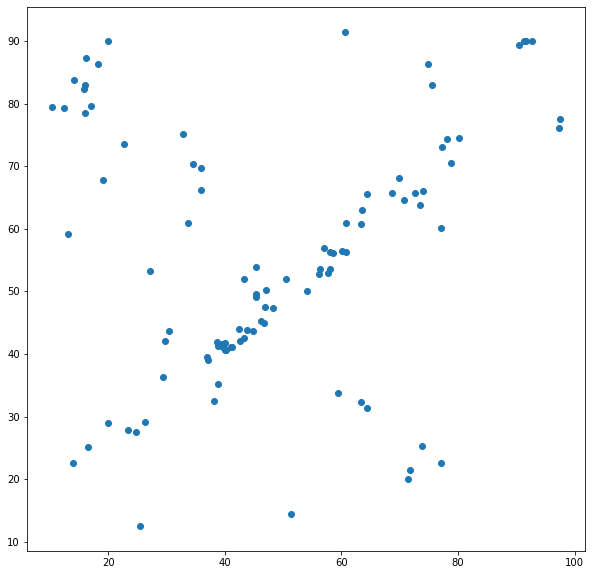

In [25]:
draw_boids(model)

NameError: name 'np' is not defined